# **CLIP Zeroshot & Finetune Demo**

This notebook demonstrates how to use **CLIP** (Contrastive Language-Image Pretraining) for **zero-shot learning** and fine-tuning. CLIP is a **pretrained multimodal model** that can associate images with natural language descriptions.

## **① Loading CLIP Model & Dependencies**

🔹 **Explanation:**  
- **`clip`**: OpenAI’s CLIP model for vision-language tasks.  
- **`PIL.Image`**: Handles image loading and preprocessing.  

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

print("CLIP model loaded successfully!")

CLIP model loaded successfully!


## **② Loading CLIP Model & Dependencies**

Flickr8k is a dataset containing 8,000 images sourced from Flickr, each paired with five textual descriptions provided by human annotators, making it widely used for image captioning and multimodal learning tasks. https://www.kaggle.com/datasets/adityajn105/flickr8k

In [3]:
image_folder = "flickr8k_data/Flicker8k_Dataset"
captions_file = "flickr8k_data/Flickr8k.token.txt"

captions = {}
with open(captions_file, "r") as f:
    for line in f:
        img_name, caption = line.strip().split("\t")
        img_name = img_name.split("#")[0]  
        if img_name not in captions:
            captions[img_name] = []
        captions[img_name].append(caption)

image_names = list(captions.keys())

train_imgs, test_imgs = train_test_split(image_names, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

train_captions = {img: captions[img] for img in train_imgs}
val_captions = {img: captions[img] for img in val_imgs}
test_captions = {img: captions[img] for img in test_imgs}

In [4]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, captions, processor):
        self.image_folder = image_folder
        self.captions = list(captions.items())  # (img_name, [captions])
        self.processor = processor

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_name, texts = self.captions[idx]
        image_path = os.path.join(self.image_folder, img_name)

        # Load Image
        image = Image.open(image_path).convert("RGB")
        text = texts[0]  # Choosing the first comment

        # Processing input data
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True, max_length=77)
        return {k: v.squeeze(0) for k, v in inputs.items()}

In [5]:
train_dataset = Flickr8kDataset(image_folder, train_captions, processor)
val_dataset = Flickr8kDataset(image_folder, val_captions, processor)
test_dataset = Flickr8kDataset(image_folder, test_captions, processor)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(f"Dataset loaded: {len(train_dataset)} images with captions.")

Dataset loaded: 6472 images with captions.


In [6]:
for param in model.vision_model.parameters():
    param.requires_grad = False
for param in model.text_model.parameters():
    param.requires_grad = False

for param in model.visual_projection.parameters():
    param.requires_grad = True
for param in model.text_projection.parameters():
    param.requires_grad = True

print("Only projection layers are trainable now.")

Only projection layers are trainable now.


## **③ CLIP Model Architecture**


In [7]:
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6)

num_epochs = 3 
model.train()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

## **④ Finetune**


In [8]:
for epoch in range(num_epochs):
    total_train_loss = 0
    model.train()
    print(f"Starting epoch {epoch+1}/{num_epochs}...")
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        inputs = {k: v.to(device) for k, v in batch.items()}
        print(f"Processing batch {batch_idx+1}/{len(train_dataloader)}...", end="\r")

        # Getting Embedding of Image & Text
        outputs = model(**inputs)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds

        # Comtrastive Loss
        similarity = (image_features @ text_features.T)
        labels = torch.arange(similarity.shape[0]).to(device)
        loss = (F.cross_entropy(similarity, labels) + F.cross_entropy(similarity.T, labels)) / 2

        # Backpropagation
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(**inputs)
            image_features = outputs.image_embeds
            text_features = outputs.text_embeds

            similarity = image_features @ text_features.T
            labels = torch.arange(similarity.shape[0]).to(device)
            loss = (F.cross_entropy(similarity, labels) + F.cross_entropy(similarity.T, labels)) / 2
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")    

print("Fine-tuning complete!")

Starting epoch 1/3...


Epoch 1/3, Batch 0/809, Loss: 1.9362
Epoch 1/3, Batch 100/809, Loss: 1.9481
Epoch 1/3, Batch 200/809, Loss: 1.8991
Epoch 1/3, Batch 300/809, Loss: 1.8838
Epoch 1/3, Batch 400/809, Loss: 1.8606
Epoch 1/3, Batch 500/809, Loss: 1.8911
Epoch 1/3, Batch 600/809, Loss: 1.8491
Epoch 1/3, Batch 700/809, Loss: 1.8002
Epoch 1/3, Batch 800/809, Loss: 1.8279
Epoch 1/3, Train Loss: 1.8656
Epoch 1/3, Validation Loss: 1.7635
Starting epoch 2/3...
Epoch 2/3, Batch 0/809, Loss: 1.7813
Epoch 2/3, Batch 100/809, Loss: 1.7803
Epoch 2/3, Batch 200/809, Loss: 1.7422
Epoch 2/3, Batch 300/809, Loss: 1.6676
Epoch 2/3, Batch 400/809, Loss: 1.7348
Epoch 2/3, Batch 500/809, Loss: 1.6936
Epoch 2/3, Batch 600/809, Loss: 1.7053
Epoch 2/3, Batch 700/809, Loss: 1.7023
Epoch 2/3, Batch 800/809, Loss: 1.6464
Epoch 2/3, Train Loss: 1.7246
Epoch 2/3, Validation Loss: 1.6540
Starting epoch 3/3...
Epoch 3/3, Batch 0/809, Loss: 1.8404
Epoch 3/3, Batch 100/809, Loss: 1.7353
Epoch 3/3, Batch 200/809, Loss: 1.6462
Epoch 3/3, Ba

## **⑤ Inference of finetuned model**


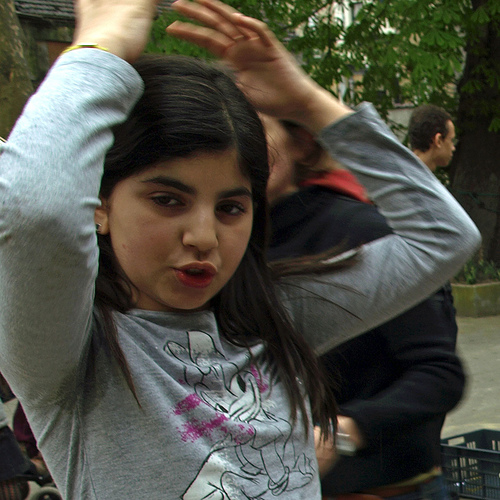

Image: 2435166927_28b8130660.jpg
True Captions: ['A girl in a gray shit is throwing her hands up .', 'A girl in a grey shirt puts her hands over her head in a gesture .', 'A young dark haired girl with her hands raised over her head .', 'A young girl in a grey illustrated shirt is holding her hands over her head .', 'A young girl raises her arms over her head in front of a couple of other people in the park .']
Candidate Captions: ['A dog running on the grass.', 'A girl in a grey shirt puts her hands over her head in a gesture .', 'A child playing in the pool.', 'A car driving on a highway.', 'A group of people hiking in the mountains.', 'A girl in a gray shit is throwing her hands up .', 'A cat sitting on the sofa.']


In [9]:
test_img_name = random.choice(list(test_captions.keys()))
image_path = os.path.join(image_folder, test_img_name)
image = Image.open(image_path).convert("RGB")

image.show()

true_captions = test_captions[test_img_name]
print(f"Image: {test_img_name}")
print(f"True Captions: {true_captions}")

distractor_captions = [
    "A cat sitting on the sofa.",
    "A group of people hiking in the mountains.",
    "A child playing in the pool.",
    "A car driving on a highway.",
    "A dog running on the grass."
]

captions = true_captions[:2] + distractor_captions 
random.shuffle(captions)

print("Candidate Captions:", captions)

In [10]:
# image_path = "flickr8k_data/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"
# image = Image.open(image_path).convert("RGB")

# image.show()

# captions = [
#     "A dog running on the beach.",
#     "A man riding a bicycle.",
#     "A child playing in a playground.",
#     "A woman sitting on a bench reading a book.",
#     "A little girl climbing into a wooden playhouse."
# ]

In [11]:
inputs = processor(text=captions, images=image, return_tensors="pt", padding=True).to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # (1, num_captions)
    probs = logits_per_image.softmax(dim=1) 

print("\nMatching Results:")
for i, caption in enumerate(captions):
    print(f"Text: {caption}\nProbability: {probs[0][i].item():.4f}\n")


Matching Results:
Text: A dog running on the grass.
Probability: 0.0000

Text: A girl in a grey shirt puts her hands over her head in a gesture .
Probability: 1.0000

Text: A child playing in the pool.
Probability: 0.0000

Text: A car driving on a highway.
Probability: 0.0000

Text: A group of people hiking in the mountains.
Probability: 0.0000

Text: A girl in a gray shit is throwing her hands up .
Probability: 0.0000

Text: A cat sitting on the sofa.
Probability: 0.0000



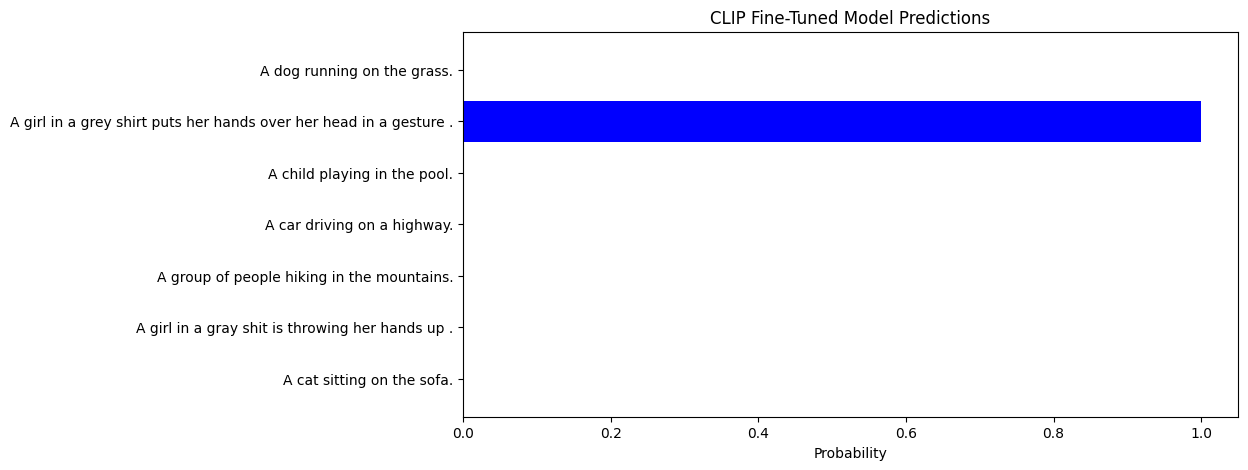

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(captions, probs.cpu().numpy().flatten(), color="blue")
plt.xlabel("Probability")
plt.title("CLIP Fine-Tuned Model Predictions")
plt.gca().invert_yaxis()  
plt.show()

## **⑥ What if Zero-Shot?**


In [13]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

inputs = processor(text=captions, images=image, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image 
    probs = logits_per_image.softmax(dim=1)  

for i, caption in enumerate(captions):
    print(f"Text: {caption}\nProbability: {probs[0][i].item():.4f}\n")

Text: A dog running on the grass.
Probability: 0.0000

Text: A girl in a grey shirt puts her hands over her head in a gesture .
Probability: 0.9229

Text: A child playing in the pool.
Probability: 0.0001

Text: A car driving on a highway.
Probability: 0.0000

Text: A group of people hiking in the mountains.
Probability: 0.0000

Text: A girl in a gray shit is throwing her hands up .
Probability: 0.0770

Text: A cat sitting on the sofa.
Probability: 0.0000



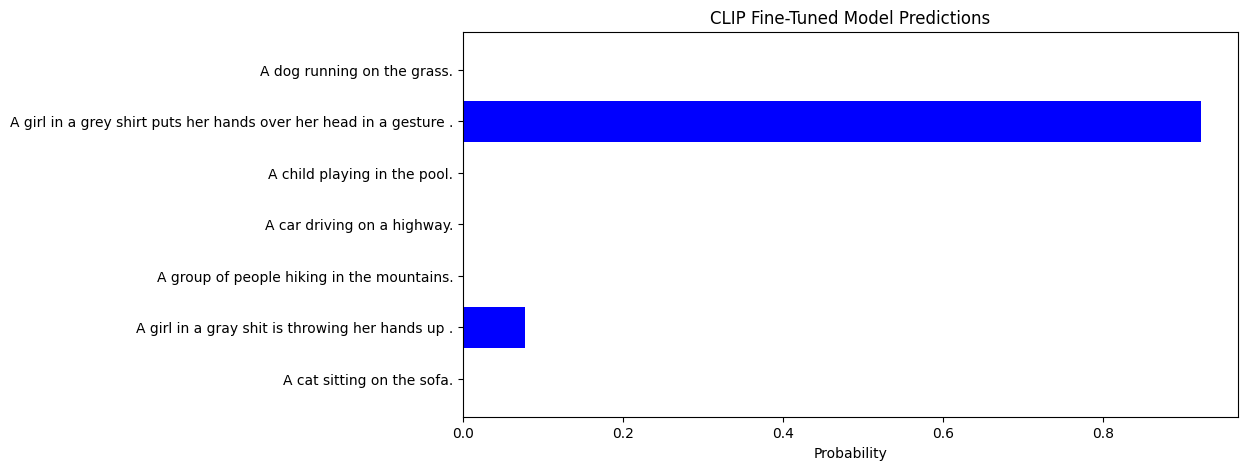

In [14]:
plt.figure(figsize=(10, 5))
plt.barh(captions, probs.cpu().numpy().flatten(), color="blue")
plt.xlabel("Probability")
plt.title("CLIP Fine-Tuned Model Predictions")
plt.gca().invert_yaxis()  
plt.show()

The finetuned model performs well on Flickr8k dataset, but it sticks to one correct text even when there are actually two correct, resulting from CLIP's original training on datasets mainly consists of One-Image to One-Text pairs.